In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score, auc
from sklearn.metrics import roc_auc_score

In [3]:
%matplotlib inline
plt.style.use('bmh')

In [4]:
# self created packages
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from scripts.visualizations import Visualization
from scripts.snowflake_sink import SnowflakeConnector

In [5]:
sns.set_theme(style="whitegrid")

In [6]:
# pyspakr ML library
from pyspark.ml.feature import VectorAssembler, ChiSqSelector, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

In [7]:
# pyspark packages
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, sum, desc, split, length, initcap, trim, lower, count, when)
from pyspark.sql.types import (
    StructType, StructField, IntegerType, StringType,
    FloatType, BooleanType, DateType, DoubleType)

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [9]:
spark = SparkSession.builder \
    .appName("Data Modeling") \
    .getOrCreate()

spark

24/12/03 19:41:24 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [10]:
ip_data = spark.read.option("header", "True") \
                .option("inferSchema", "True") \
                .option("quote", '"') \
                .option("escape", '"') \
                .option("sep", ",") \
                .option("ignoreLeadingWhiteSpace", "True") \
                .option("ignoreTrailingWhiteSpace", "True") \
                .option("multiLine", "True") \
                .option("mode", "PERMISSIVE") \
                .csv("../data/gun_violence_cleaned_data_2013_2018.csv")

print(f"Number of records in the data : {ip_data.count()}")
print(f"Number of columns: {len(ip_data.columns)}")

Number of records in the data : 239677
Number of columns: 45


In [11]:
txt_columns = ["notes"]

ip_data = ip_data.fillna("missing", subset=txt_columns)

### Classification (without the text column)

For startes we are setting the target column as `is_killed` a new column created and proceed with the classification problem.

We will also drop features such as `incident_id`, `notes`, `date`, `city_or_county`, and may be `incident_characteristics`, `year`

Not sure if `year` is needed as it might be missleading.

In [13]:
class_ip_data = ip_data.withColumn("is_killed", when(col("n_killed") > 0, 1).otherwise(0))

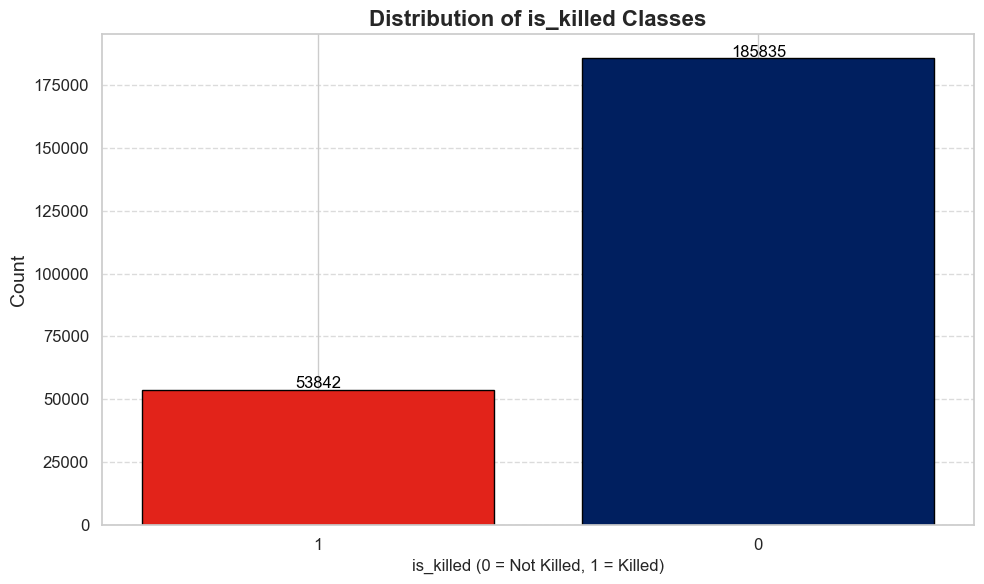

In [14]:
class_distribution = class_ip_data.groupBy("is_killed").count().toPandas()

plt.figure(figsize=(10, 6))
colors = ['#E2231A', '#001F5F']

plt.bar(class_distribution['is_killed'].astype(str), class_distribution['count'], color=colors, edgecolor='black')
plt.title('Distribution of is_killed Classes', fontsize=16, fontweight='bold')
plt.xlabel('is_killed (0 = Not Killed, 1 = Killed)', fontsize=12)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12, rotation=0, ha='center')
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, value in enumerate(class_distribution['count']):
    plt.text(i, value + 500, str(value), ha='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()

Given that the data is imbalanced, one effective approach to handle this issue is by applying class weights during training. This technique adjusts the model's learning process, assigning higher importance to the minority class and ensuring it is adequately represented in the training phase. By using class weights, the model is penalized more heavily for misclassifying examples from the underrepresented class, which can lead to improved performance, especially in imbalanced scenarios.

Alternatively, other popular techniques to address class imbalance include synthetic sampling methods like SMOTE (Synthetic Minority Over-sampling Technique) or various undersampling methods. SMOTE works by generating synthetic examples for the minority class, whereas undersampling reduces the number of instances from the majority class to balance the dataset.

For now, we will begin with using class weights during training, as it is a simple and efficient solution that can be implemented directly into the training process. If necessary, we can explore other sampling techniques later to further improve model performance.

In [16]:
pandas_ip_data = class_ip_data.toPandas()

24/12/03 19:41:33 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [17]:
columns = [
    "incident_id", "n_killed", "n_injured", "congressional_district", "latitude", "longitude", "n_guns_involved",
    "year", "month", "day_of_week", "gun_stolen_not_stolen_freq", "gun_stolen_stolen_freq",
    "gun_stolen_unknown_freq", "gun_type_ak_freq", "gun_type_auto_freq", "gun_type_gauge_freq",
    "gun_type_handgun_freq", "gun_type_lr_freq", "gun_type_mag_freq", "gun_type_mm_freq",
    "gun_type_rem_ar_freq", "gun_type_rifle_freq", "gun_type_shotgun_freq", "gun_type_spl_freq",
    "gun_type_spr_freq", "gun_type_sw_freq", "gun_type_unknown_freq", "gun_type_win_freq",
    "participant_age_group_adult_18plus_freq", "participant_age_group_child_0_11_freq",
    "participant_age_group_teen_12_17_freq", "participant_gender_female_freq",
    "participant_gender_male_freq", "participant_status_arrested_freq",
    "participant_status_injured_freq", "participant_status_killed_freq",
    "participant_status_unharmed_freq", "participant_type_subject_suspect_freq",
    "participant_type_victim_freq", "is_killed"]

In [18]:
df_corr = pandas_ip_data[columns]

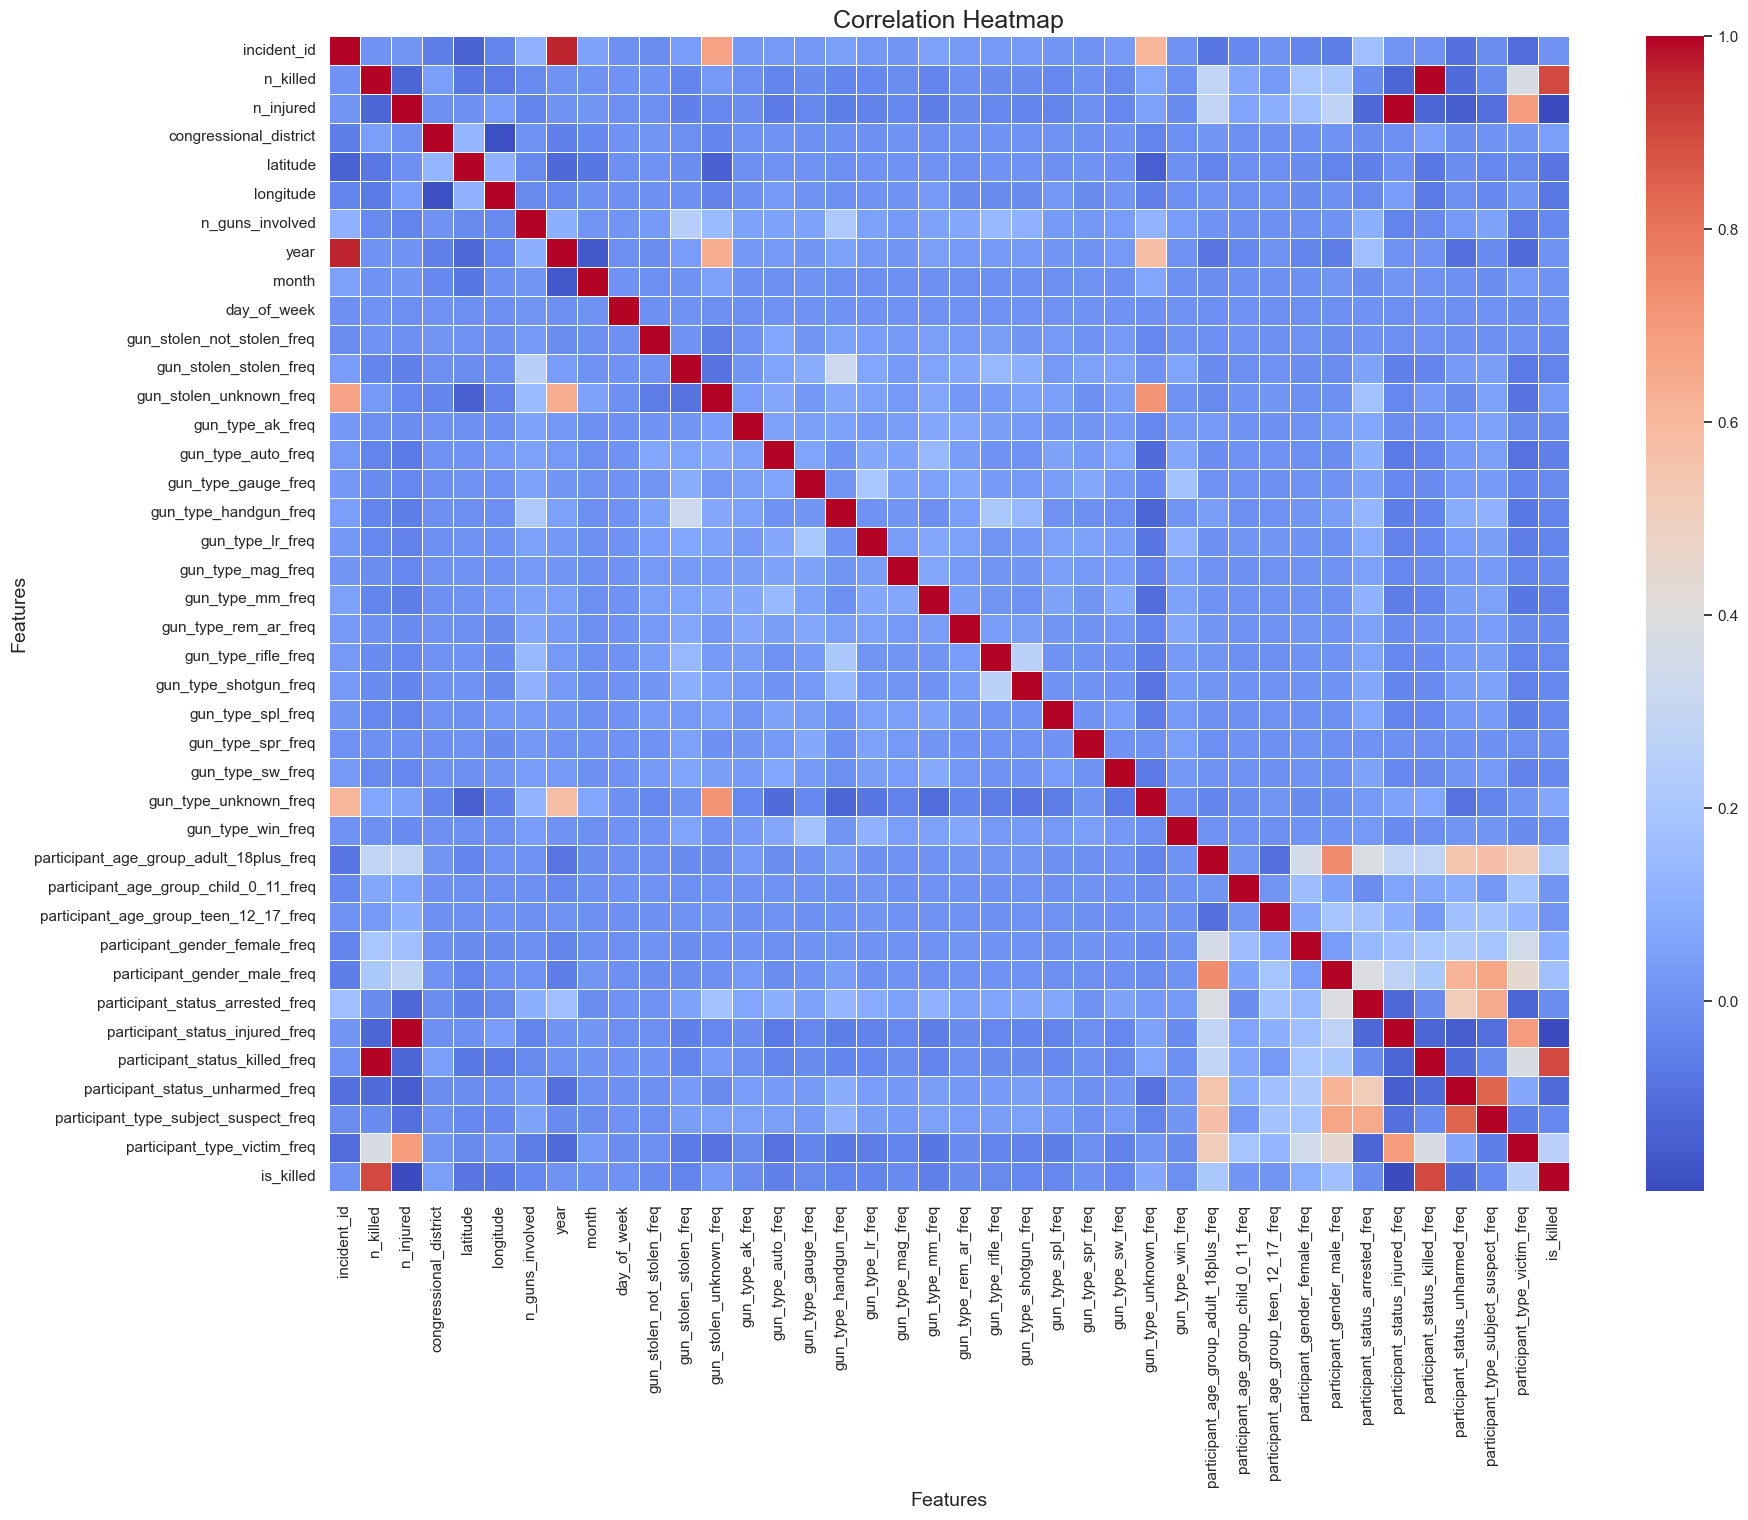

In [19]:
correlation_matrix = df_corr.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, linewidths=0.5)

plt.title("Correlation Heatmap", fontsize=18)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Features", fontsize=14)

plt.show()

Dropping columns which we won't be using.

In [21]:
cols_to_drop = ["n_killed", "incident_id", "date", "address", "congressional_district", 
                "incident_characteristics", "latitude", "longitude", "notes", "city_or_county",
                "participant_status_injured_freq", "participant_status_killed_freq", "participant_status_arrested_freq",
                "participant_status_unharmed_freq", "participant_type_subject_suspect_freq", "participant_type_victim_freq"]

class_ip_data = class_ip_data.drop(*cols_to_drop)

In [22]:
non_numeric_columns = [field.name for field in class_ip_data.schema.fields if not isinstance(field.dataType, (IntegerType, FloatType, DoubleType))]

print("Non-integer and non-float columns:", non_numeric_columns)

Non-integer and non-float columns: ['state']


In [23]:
def encode_multiple_columns_with_string_indexer(df, columns):
    """
    Function to encode multiple columns using StringIndexer.
    
    Parameters:
    df (DataFrame): The input DataFrame.
    columns (list): List of column names to be indexed.
    
    Returns:
    DataFrame: DataFrame with the new indexed columns.
    """
    indexers = [StringIndexer(inputCol=cols, outputCol=cols + "_indexed") for cols in columns]
    
    pipeline = Pipeline(stages=indexers)
    indexed_df = pipeline.fit(df).transform(df)
    
    return indexed_df

In [24]:
train_data, temp_data = class_ip_data.randomSplit([0.6, 0.4], seed=42)
validation_data, test_data = temp_data.randomSplit([0.5, 0.5], seed=42)

In [25]:
train_data = encode_multiple_columns_with_string_indexer(train_data, non_numeric_columns)
validation_data = encode_multiple_columns_with_string_indexer(validation_data, non_numeric_columns)
test_data = encode_multiple_columns_with_string_indexer(test_data, non_numeric_columns)

In [26]:
train_data = train_data.drop(*non_numeric_columns)
validation_data = validation_data.drop(*non_numeric_columns)
test_data = test_data.drop(*non_numeric_columns)

In [27]:
for cols in non_numeric_columns:
    train_data = train_data.withColumnRenamed(cols + "_indexed", cols)
    validation_data = validation_data.withColumnRenamed(cols + "_indexed", cols)
    test_data = test_data.withColumnRenamed(cols + "_indexed", cols)

#### Feature Vectorization

In [29]:
feature_columns = [cols for cols in train_data.columns if cols not in ['is_killed']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [30]:
train_data = assembler.transform(train_data).select("features", "is_killed")
validation_data = assembler.transform(validation_data).select("features", "is_killed")
test_data = assembler.transform(test_data).select("features", "is_killed")

### Training with Class Weights to handle Class Imbalance

In [32]:
class_counts = train_data.groupBy("is_killed").count().collect()
total_count = train_data.count()
weights = {row['is_killed']: total_count / row['count'] for row in class_counts}

In [33]:
train_data_cl_wghts = train_data.select("*")

In [34]:
train_data_cl_wghts = train_data_cl_wghts.withColumn("weight", when(col("is_killed") == 1, weights[1]).otherwise(weights[0]))

#### Model Training and Evaluation

In [36]:
log_reg = LogisticRegression(featuresCol='features', labelCol='is_killed', weightCol='weight')
rf = RandomForestClassifier(featuresCol='features', labelCol='is_killed', weightCol='weight', maxBins=64, seed=42)
dt = DecisionTreeClassifier(featuresCol='features', labelCol='is_killed', weightCol='weight', maxBins=64, seed=42)
gbt = GBTClassifier(featuresCol='features', labelCol='is_killed', weightCol='weight', maxBins=64, seed=42)

In [37]:
models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf,
    'Decision Tree': dt,
    'GBT': gbt
}

evaluator = BinaryClassificationEvaluator(labelCol="is_killed", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

In [38]:
model_performance = {}
best_model = None
best_auc = 0.0

for model_name, model in models.items():
    trained_model = model.fit(train_data_cl_wghts)
    train_predictions = trained_model.transform(train_data_cl_wghts)
    val_predictions = trained_model.transform(validation_data)
    
    train_auc = evaluator.evaluate(train_predictions)
    val_auc = evaluator.evaluate(val_predictions)
    
    val_df = val_predictions.select('is_killed', 'probability').toPandas()
    y_true = val_df['is_killed']
    y_scores = val_df['probability'].apply(lambda x: float(x[1]))  # Probability of class 1
    y_pred = val_df['probability'].apply(lambda x: 1 if x[1] >= 0.5 else 0)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    model_performance[model_name] = {
        'Train AUC': train_auc, 
        'Validation AUC': val_auc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Accuracy': accuracy
    }
    
    if val_auc > best_auc:
        best_auc = val_auc
        best_model = trained_model

    print(f"{model_name} - AUC: {val_auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

print(f"\nBest Model: {best_model.__class__.__name__} with AUC: {best_auc:.4f}")

24/12/03 19:41:58 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Logistic Regression - AUC: 0.8224, Precision: 0.4843, Recall: 0.8058, F1 Score: 0.6050, Accuracy: 0.7614


Random Forest - AUC: 0.8346, Precision: 0.4550, Recall: 0.8170, F1 Score: 0.5845, Accuracy: 0.7366


Decision Tree - AUC: 0.8241, Precision: 0.4716, Recall: 0.8216, F1 Score: 0.5993, Accuracy: 0.7508


GBT - AUC: 0.8661, Precision: 0.4841, Recall: 0.8473, F1 Score: 0.6162, Accuracy: 0.7606

Best Model: GBTClassificationModel with AUC: 0.8661


In [39]:
model_names = list(model_performance.keys())
train_aucs = [model_performance[model]['Train AUC'] for model in model_names]
val_aucs = [model_performance[model]['Validation AUC'] for model in model_names]

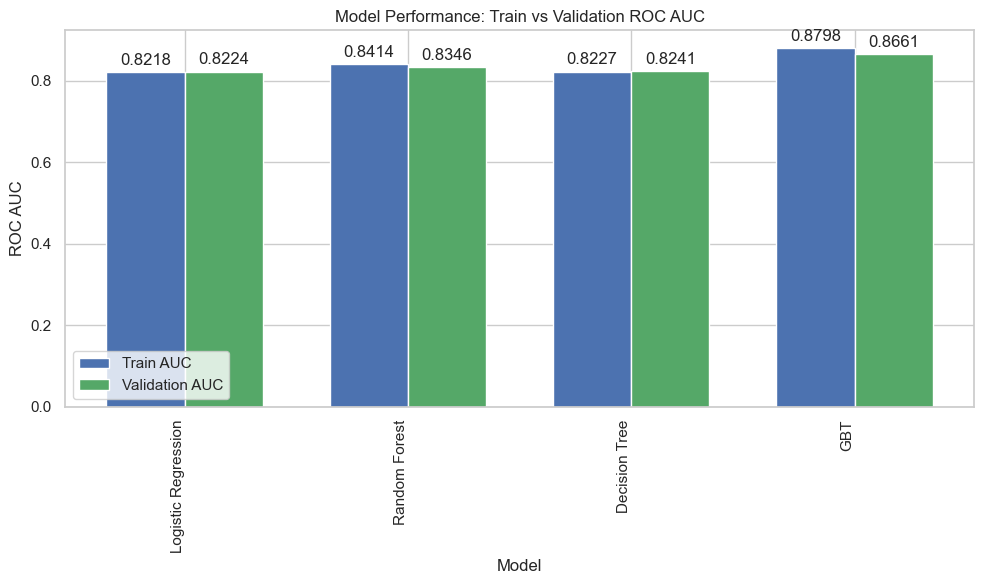

In [40]:
x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_aucs, width, label='Train AUC', color='b')
rects2 = ax.bar(x + width/2, val_aucs, width, label='Validation AUC', color='g')

ax.set_xlabel('Model')
ax.set_ylabel('ROC AUC')
ax.set_title('Model Performance: Train vs Validation ROC AUC')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=90, ha="right")
ax.legend()

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
plt.tight_layout()
plt.show()

In [41]:
test_predictions = best_model.transform(test_data)
final_auc = evaluator.evaluate(test_predictions)

print(f"\nBest Model: {best_model.__class__.__name__} with Validation AUC: {best_auc:.4f}")
print(f"Final AUC on Test Data: {final_auc:.4f}")


Best Model: GBTClassificationModel with Validation AUC: 0.8661
Final AUC on Test Data: 0.8679


In [42]:
test_predictions_df = test_predictions.select('is_killed', 'probability').toPandas()

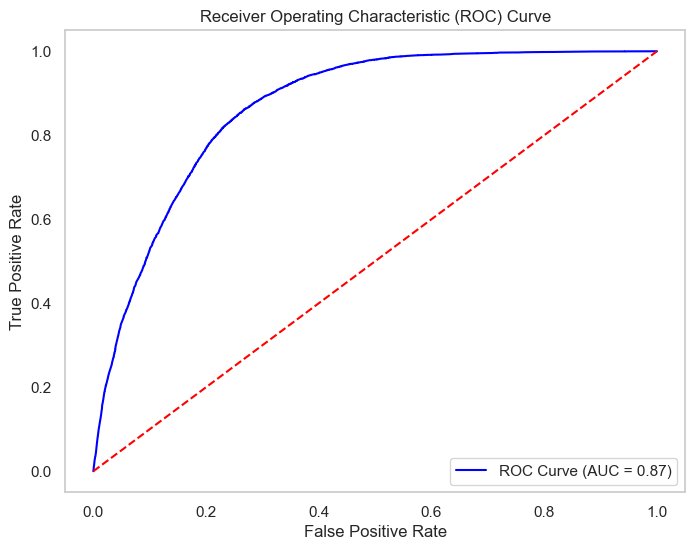

In [43]:
y_true = test_predictions_df['is_killed']
y_scores = test_predictions_df['probability'].apply(lambda x: float(x[1]))  # Probability of class 1

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [44]:
y_pred = test_predictions_df['probability'].apply(lambda x: 1 if x[1] >= 0.5 else 0)
conf_matrix = confusion_matrix(y_true, y_pred)

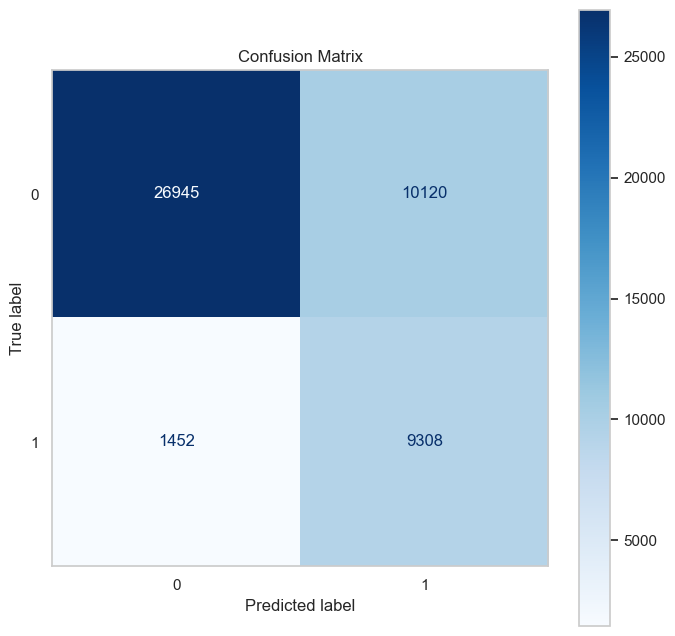

In [45]:
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d', ax=ax)
ax.grid(False)
plt.title("Confusion Matrix")
plt.show()

In [46]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
accuracy = accuracy_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.4791
Recall: 0.8651
F1 Score: 0.6167
Accuracy: 0.7580


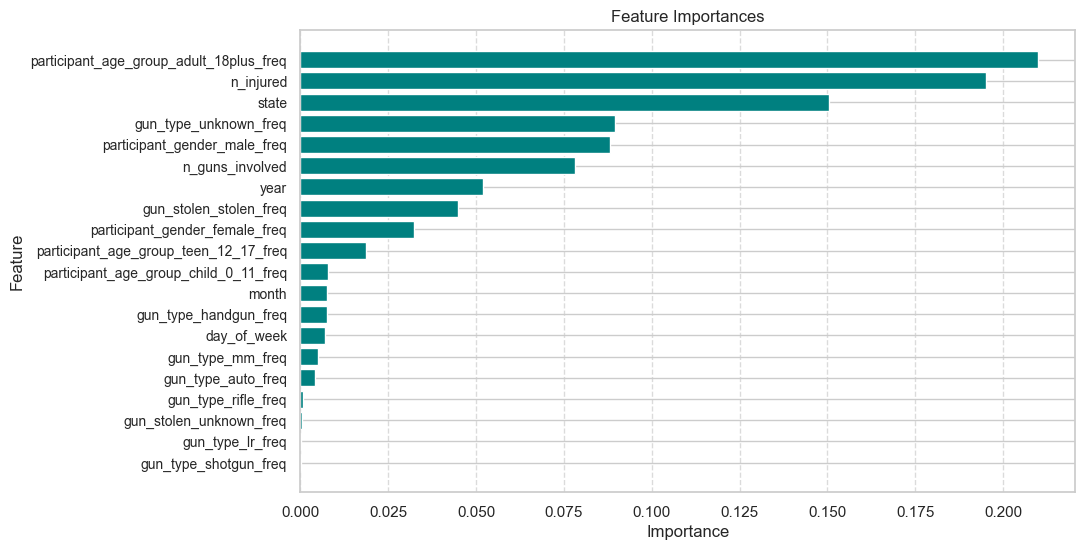

In [47]:
if hasattr(best_model, "featureImportances"):
    feature_importances = best_model.featureImportances.toArray()

    non_zero_features = [(feature, importance) for feature, importance in zip(feature_columns, feature_importances) if importance > 0]
    feature_importances_df = pd.DataFrame(non_zero_features, columns=['feature', 'importance'])
    
    feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances_df['feature'], feature_importances_df['importance'], color='teal')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.yticks(fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.gca().invert_yaxis()

    plt.show()
else:
    print("Feature importance is not available for this model.")

### Hyperparameter Tuning - on the best model

We have gotten the Gradient Boosting the best model, so we will be performing hyper parameter tuning.

In [49]:
gbt = GBTClassifier(featuresCol='features', labelCol='is_killed', weightCol='weight', seed=42)

In [50]:
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 7]) \
    .addGrid(gbt.maxBins, [64, 96, 128]) \
    .addGrid(gbt.maxIter, [20, 30, 40]) \
    .build()

In [51]:
cv = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    seed=42
)

In [52]:
%%time
cv_model = cv.fit(train_data_cl_wghts)

24/12/03 19:48:19 WARN DAGScheduler: Broadcasting large task binary with size 1001.4 KiB
24/12/03 19:48:19 WARN DAGScheduler: Broadcasting large task binary with size 1010.3 KiB
24/12/03 19:48:19 WARN DAGScheduler: Broadcasting large task binary with size 1010.8 KiB
24/12/03 19:48:19 WARN DAGScheduler: Broadcasting large task binary with size 1011.3 KiB
24/12/03 19:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1013.0 KiB
24/12/03 19:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1017.4 KiB
24/12/03 19:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1023.2 KiB
24/12/03 19:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1035.0 KiB
24/12/03 19:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1044.6 KiB
24/12/03 19:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1045.1 KiB
24/12/03 19:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1045.7 KiB
24/12/03 19:48:21 WAR

CPU times: user 1.53 s, sys: 848 ms, total: 2.38 s
Wall time: 25min 21s


In [53]:
best_model = cv_model.bestModel

print("Best Model Parameters:")
print(f"maxDepth: {best_model.getMaxDepth()}")
print(f"maxBins: {best_model.getMaxBins()}")
print(f"maxIter: {best_model.getMaxIter()}")
print(f"stepSize: {best_model.getStepSize()}")

Best Model Parameters:
maxDepth: 7
maxBins: 128
maxIter: 40
stepSize: 0.1


In [54]:
def plot_parameter_performance(cv_model, paramGrid):
    metrics = cv_model.avgMetrics
    param_combinations = []
    
    for params in paramGrid:
        param_str = f"D={params[gbt.maxDepth]}\nB={params[gbt.maxBins]}\nI={params[gbt.maxIter]}"
        param_combinations.append(param_str)
    
    plt.figure(figsize=(15, 6))
    bars = plt.bar(range(len(metrics)), metrics)
    plt.xlabel('Parameter Combinations\n(D=maxDepth, B=maxBins, I=maxIter)')
    plt.ylabel('Average AUC-ROC')
    plt.title('Parameter Combination Performance')
    plt.xticks(range(len(metrics)), param_combinations, rotation=45, ha='right')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


Plotting parameter combination performance...


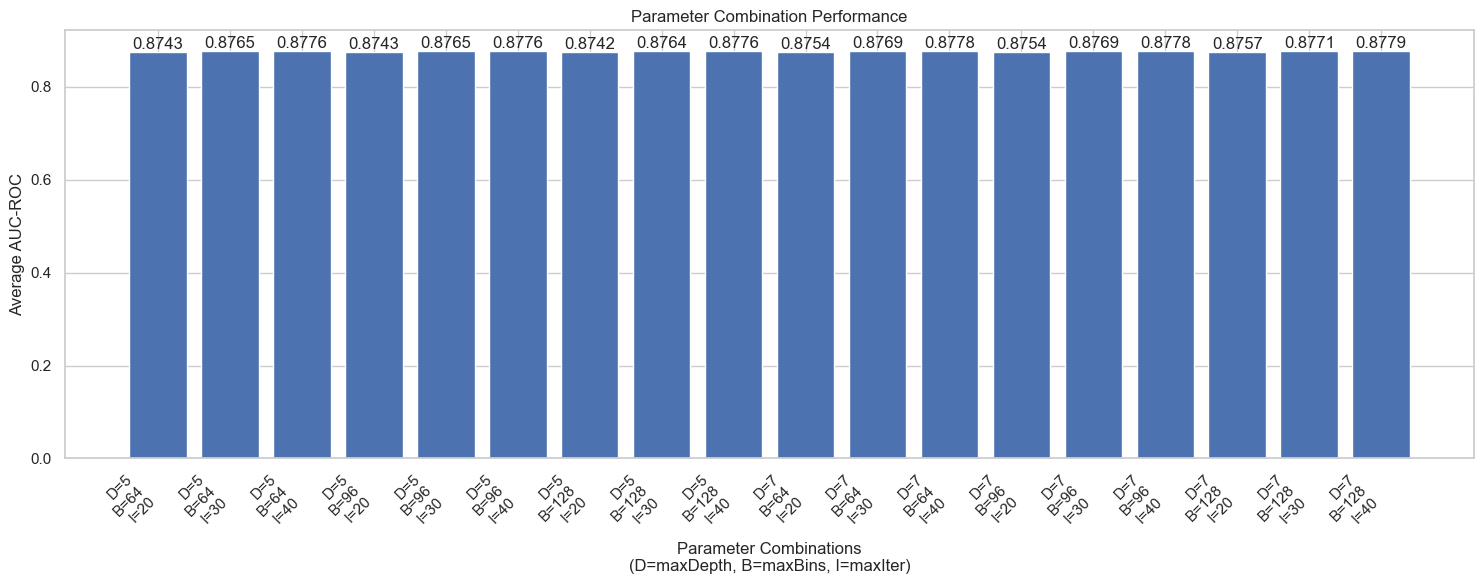

In [55]:
print("\nPlotting parameter combination performance...")
plot_parameter_performance(cv_model, paramGrid)

In [56]:
def plot_parameter_impact(cv_model, paramGrid):
    metrics = cv_model.avgMetrics
    params_dict = {
        'maxDepth': {},
        'maxBins': {},
        'maxIter': {}
    }
    
    for i, params in enumerate(paramGrid):
        for param_name in params_dict.keys():
            param_value = params[getattr(gbt, param_name)]
            if param_value not in params_dict[param_name]:
                params_dict[param_name][param_value] = []
            params_dict[param_name][param_value].append(metrics[i])
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Impact of Individual Parameters on Model Performance')
    
    for ax, (param_name, param_metrics) in zip(axes, params_dict.items()):
        values = sorted(param_metrics.keys())
        means = [np.mean(param_metrics[v]) for v in values]
        stds = [np.std(param_metrics[v]) for v in values]
        
        ax.errorbar(values, means, yerr=stds, marker='o')
        ax.set_xlabel(param_name)
        ax.set_ylabel('Average AUC-ROC')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()


Plotting parameter impact analysis...


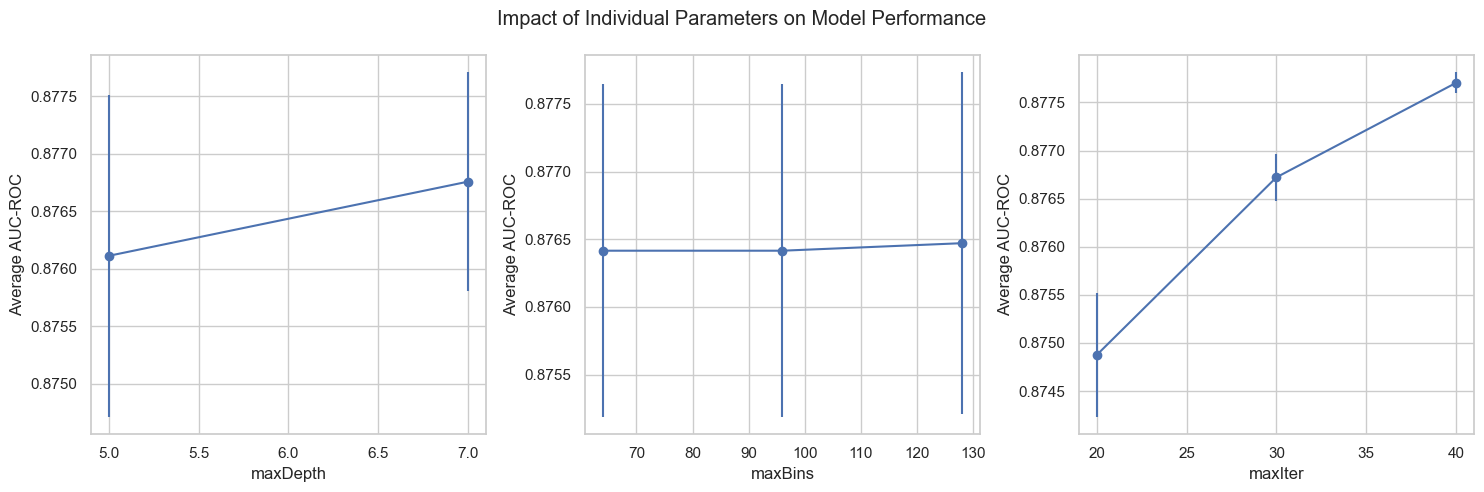

In [57]:
print("\nPlotting parameter impact analysis...")
plot_parameter_impact(cv_model, paramGrid)

In [114]:
val_predictions = best_model.transform(test_data)
val_final_auc = evaluator.evaluate(val_predictions)
print(val_final_auc)

24/12/03 20:16:39 WARN DAGScheduler: Broadcasting large task binary with size 1515.9 KiB


0.8725941290719563


In [112]:
val_predictions_df = val_predictions.select("is_killed", "probability").toPandas()
yval_true = val_predictions_df['is_killed']
yval_pred = val_predictions_df['probability'].apply(lambda x: 1 if x[1] >= 0.5 else 0)

precision, recall, f1_score, _ = precision_recall_fscore_support(yval_true, yval_pred, average='binary')
accuracy = accuracy_score(yval_true, yval_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

24/12/03 20:15:22 WARN DAGScheduler: Broadcasting large task binary with size 1513.8 KiB


Precision: 0.4929
Recall: 0.8574
F1 Score: 0.6260
Accuracy: 0.7695


In [116]:
test_predictions = best_model.transform(test_data)
final_auc = evaluator.evaluate(test_predictions)
print(f"\nFinal Test Set AUC: {final_auc:.4f}")

24/12/03 20:17:29 WARN DAGScheduler: Broadcasting large task binary with size 1515.9 KiB



Final Test Set AUC: 0.8726


24/12/03 20:17:31 WARN DAGScheduler: Broadcasting large task binary with size 1513.8 KiB


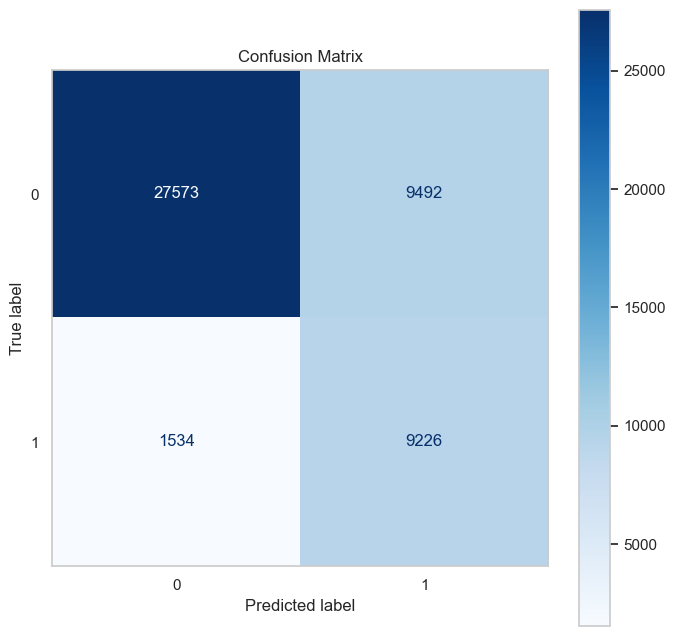

In [117]:
test_predictions_df = test_predictions.select("is_killed", "probability").toPandas()
y_true = test_predictions_df['is_killed']
y_pred = test_predictions_df['probability'].apply(lambda x: 1 if x[1] >= 0.5 else 0)

conf_matrix = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d', ax=ax)
ax.grid(False)
plt.title("Confusion Matrix")
plt.show()

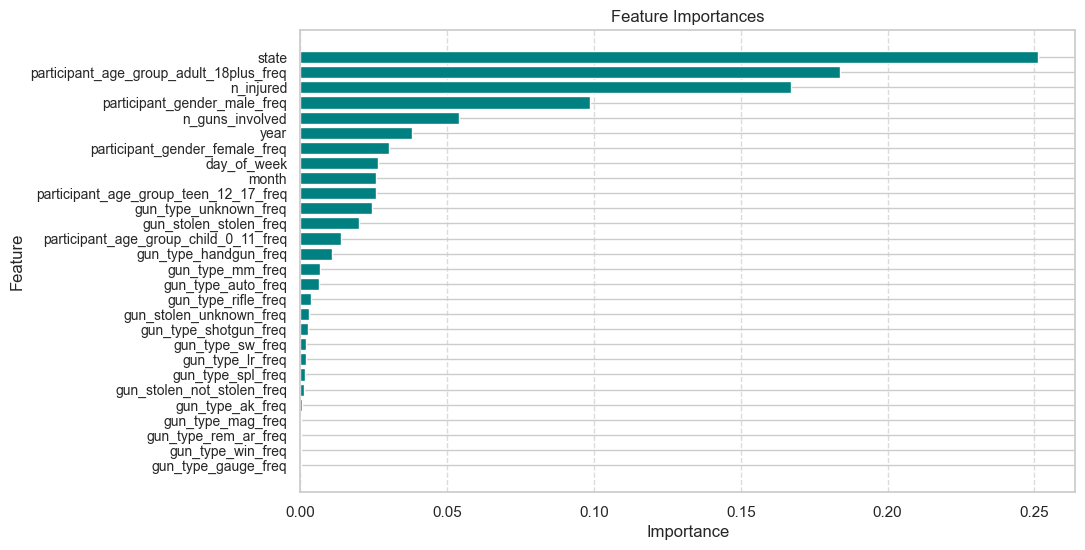


Top 10 Most Important Features (feature, importance):
Feature: state, Importance: 0.2514
Feature: participant_age_group_adult_18plus_freq, Importance: 0.1838
Feature: n_injured, Importance: 0.1671
Feature: participant_gender_male_freq, Importance: 0.0985
Feature: n_guns_involved, Importance: 0.0540
Feature: year, Importance: 0.0379
Feature: participant_gender_female_freq, Importance: 0.0301
Feature: day_of_week, Importance: 0.0263
Feature: month, Importance: 0.0257
Feature: participant_age_group_teen_12_17_freq, Importance: 0.0256


In [118]:
if hasattr(best_model, "featureImportances"):
    feature_importances = best_model.featureImportances.toArray()

    non_zero_features = [(feature, importance) for feature, importance in zip(feature_columns, feature_importances) if importance > 0]
    feature_importances_df = pd.DataFrame(non_zero_features, columns=['feature', 'importance'])
    feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances_df['feature'], feature_importances_df['importance'], color='teal')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.yticks(fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.gca().invert_yaxis()
    plt.show()

    top_features = feature_importances_df.head(10)
    print("\nTop 10 Most Important Features (feature, importance):")
    for idx, row in top_features.iterrows():
        print(f"Feature: {row['feature']}, Importance: {row['importance']:.4f}")
else:
    print("Feature importance is not available for this model.")

### Severity Classification of Incidents Based on Fatalities and Injuries

The approach to classify the severity of incidents based on fatalities and injuries involves assigning distinct weights to each, recognizing that fatalities carry greater significance than injuries. In this system, each death (`n_killed`) is assigned a weight of 2.01 points, while each injury (`n_injured`) is assigned 1 point, reflecting the greater impact of fatalities. A severity score is then calculated for each incident as the weighted sum of these values: 

The severity score is then used to categorize incidents into three distinct levels of severity:

- **Low Severity** (encoded as 1): A severity score of 0, typically representing incidents with no fatalities and no injuries.
- **Moderate Severity** (encoded as 2): A score between 0 and 2, indicating incidents with minor injuries or a very low number of fatalities.
- **High Severity** (encoded as 3): A score greater than 2, suggesting incidents with more serious injuries or multiple fatalities.

This weighted and categorized system offers a simple and scalable method to assess the severity of incidents, ensuring that cases with higher fatalities or combined fatalities and injuries are appropriately classified as more severe.

In [122]:
severity_ip_data = ip_data.select("*")

In [124]:
severity_ip_data = severity_ip_data.withColumn("severity_score", col("n_killed") * 2.01 + col("n_injured"))

In [126]:
severity_ip_data = severity_ip_data.withColumn("severity_category", 
                                               when(col("severity_score") <= 0, 0)
                                               .when((col("severity_score") > 0) & (col("severity_score") <= 2), 1)
                                               .when((col("severity_score") > 2), 2))

In [128]:
# Showing the value counts

severity_counts = severity_ip_data.groupBy("severity_category").count()
severity_counts.show()

+-----------------+-----+
|severity_category|count|
+-----------------+-----+
|                1|85538|
|                2|56852|
|                0|97287|
+-----------------+-----+



In [129]:
severity_counts = severity_counts.toPandas()

severity_counts['severity_category'] = severity_counts['severity_category'].replace({0: 'Low', 1: 'Moderate', 2: 'High'})

severity_counts['severity_category'] = pd.Categorical(
    severity_counts['severity_category'], 
    categories=['Low', 'Moderate', 'High'], 
    ordered=True
)

severity_counts = severity_counts.sort_values('severity_category')

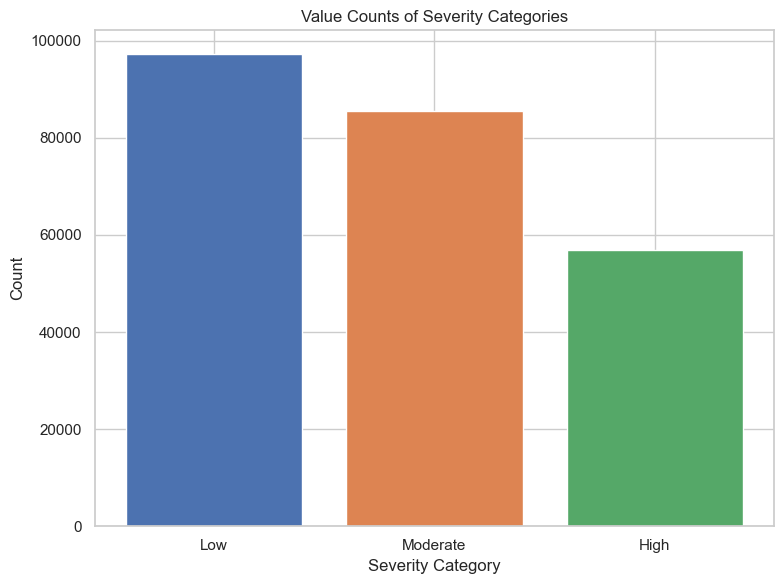

In [130]:
plt.figure(figsize=(8, 6))
plt.bar(severity_counts['severity_category'], severity_counts['count'], color=sns.color_palette()[:3])
plt.xlabel('Severity Category')
plt.ylabel('Count')
plt.title('Value Counts of Severity Categories')
plt.tight_layout()
plt.show()

It is not balanced so we would be using class weights to balance it while training.

In [135]:
sev_cols_to_drop = ["n_killed", "n_injured", "incident_id", "date", "address", "congressional_district", 
                "incident_characteristics", "latitude", "longitude", "notes", "city_or_county",
                "participant_status_injured_freq", "participant_status_killed_freq", "participant_status_arrested_freq",
                "participant_status_unharmed_freq", "participant_type_subject_suspect_freq", "participant_type_victim_freq", "severity_score"]

In [137]:
severity_ip_data = severity_ip_data.drop(*sev_cols_to_drop)

In [139]:
non_numeric_columns_sev = [field.name for field in severity_ip_data.schema.fields if not isinstance(field.dataType, (IntegerType, FloatType, DoubleType))]
print("Non-integer and non-float columns:", non_numeric_columns_sev)

Non-integer and non-float columns: ['state']


In [141]:
sev_train_data, sev_temp_data = severity_ip_data.randomSplit([0.6, 0.4], seed=42)
sev_validation_data, sev_test_data = sev_temp_data.randomSplit([0.5, 0.5], seed=42)

In [143]:
sev_train_data = encode_multiple_columns_with_string_indexer(sev_train_data, non_numeric_columns_sev)
sev_validation_data = encode_multiple_columns_with_string_indexer(sev_validation_data, non_numeric_columns_sev)
sev_test_data = encode_multiple_columns_with_string_indexer(sev_test_data, non_numeric_columns_sev)

In [144]:
sev_train_data = sev_train_data.drop(*non_numeric_columns_sev)
sev_validation_data = sev_validation_data.drop(*non_numeric_columns_sev)
sev_test_data = sev_test_data.drop(*non_numeric_columns_sev)

In [145]:
for cols in non_numeric_columns_sev:
    sev_train_data = sev_train_data.withColumnRenamed(cols + "_indexed", cols)
    sev_validation_data = sev_validation_data.withColumnRenamed(cols + "_indexed", cols)
    sev_test_data = sev_test_data.withColumnRenamed(cols + "_indexed", cols)

#### Feature Vectorization

In [147]:
sev_feature_columns = [col_name for col_name in sev_train_data.columns if col_name not in ["severity_category"]]
sev_assembler = VectorAssembler(inputCols=sev_feature_columns, outputCol="features")

In [148]:
sev_train_data = sev_assembler.transform(sev_train_data).select("features", "severity_category")
sev_validation_data = sev_assembler.transform(sev_validation_data).select("features", "severity_category")
sev_test_data = sev_assembler.transform(sev_test_data).select("features", "severity_category")

#### Training with Class Weights to handle Class Imbalance

In [150]:
severity_counts = sev_train_data.groupBy("severity_category").count().collect()

In [151]:
sev_total_count = sev_train_data.count()

sev_weights = {row['severity_category']: sev_total_count / row['count'] for row in severity_counts}

In [152]:
severity_ip_data_with_weights = sev_train_data.select("*")

In [153]:
severity_ip_data_with_weights = severity_ip_data_with_weights.withColumn(
    "severity_weight", 
    when(col("severity_category") == 0, sev_weights[0])
    .when(col("severity_category") == 1, sev_weights[1])
    .otherwise(sev_weights[2])
)

#### Model Training and Evaluation

In [176]:
sev_log_reg = LogisticRegression(featuresCol='features', labelCol='severity_category', weightCol='severity_weight')
sev_rf = RandomForestClassifier(featuresCol='features', labelCol='severity_category', weightCol='severity_weight', maxBins=64, seed=42)
sev_dt = DecisionTreeClassifier(featuresCol='features', labelCol='severity_category', weightCol='severity_weight', maxBins=64, seed=42)
# sev_gbt = GBTClassifier(featuresCol='features', labelCol='severity_category', weightCol='severity_weight', maxBins=64, seed=42)

In [184]:
sev_models = {
    'Logistic Regression': sev_log_reg,
    'Random Forest': sev_rf,
    'Decision Tree': sev_dt,
    #'GBT': sev_gbt
}

sev_evaluator = MulticlassClassificationEvaluator(labelCol='severity_category', metricName='accuracy')

In [186]:
sev_best_model = None
sev_best_auc = 0.0
sev_model_performance = {}

In [210]:
%%time
for model_name, model in sev_models.items():
    sev_trained_model = model.fit(severity_ip_data_with_weights)
    sev_train_predictions = sev_trained_model.transform(severity_ip_data_with_weights)
    sev_validation_predictions = sev_trained_model.transform(sev_validation_data)
    
    sev_train_auc = sev_evaluator.evaluate(sev_train_predictions)
    sev_val_auc = sev_evaluator.evaluate(sev_validation_predictions)
    
    sev_val_df = sev_validation_predictions.select('severity_category', 'probability').toPandas()
    y_true = sev_val_df['severity_category']
    y_pred = sev_val_df['probability'].apply(lambda x: np.argmax(x))
    
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    
    # Manually calculate F1 score
    if (precision + recall) > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0  # F1 score is 0 if precision and recall are both 0
    
    sev_model_performance[model_name] = {
        'Train AUC': sev_train_auc,
        'Validation AUC': sev_val_auc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Accuracy': accuracy
    }
    
    if sev_val_auc > sev_best_auc:
        sev_best_auc = sev_val_auc
        sev_best_model = sev_trained_model

    print(f"{model_name} - AUC: {sev_val_auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

print(f"\nBest Model: {sev_best_model.__class__.__name__} with AUC: {sev_best_auc:.4f}")

Logistic Regression - AUC: 0.5412, Precision: 0.5507, Recall: 0.5412, F1 Score: 0.5459, Accuracy: 0.5412


Random Forest - AUC: 0.5355, Precision: 0.5860, Recall: 0.5355, F1 Score: 0.5596, Accuracy: 0.5355


Decision Tree - AUC: 0.5133, Precision: 0.5876, Recall: 0.5133, F1 Score: 0.5480, Accuracy: 0.5133

Best Model: LogisticRegressionModel with AUC: 0.5412
CPU times: user 1.67 s, sys: 46.7 ms, total: 1.72 s
Wall time: 42.4 s


In [212]:
sev_model_names = list(sev_model_performance.keys())
sev_train_aucs = [sev_model_performance[model]['Train AUC'] for model in sev_model_names]
sev_val_aucs = [sev_model_performance[model]['Validation AUC'] for model in sev_model_names]

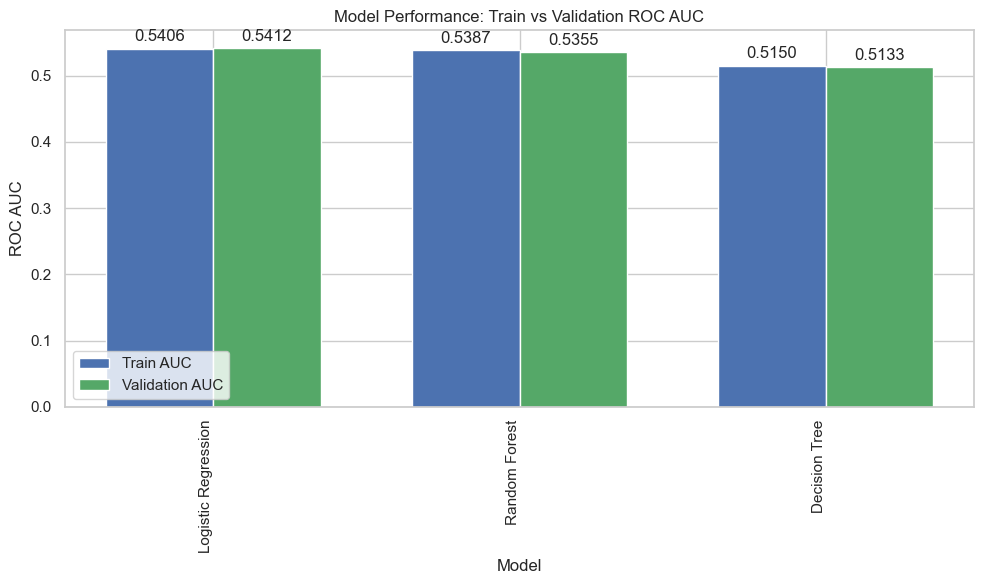

In [214]:
sev_x = np.arange(len(sev_model_names))
sev_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(sev_x - sev_width/2, sev_train_aucs, sev_width, label='Train AUC', color='b')
rects2 = ax.bar(sev_x + sev_width/2, sev_val_aucs, sev_width, label='Validation AUC', color='g')

ax.set_xlabel('Model')
ax.set_ylabel('ROC AUC')
ax.set_title('Model Performance: Train vs Validation ROC AUC')
ax.set_xticks(sev_x)
ax.set_xticklabels(sev_model_names, rotation=90, ha="right")
ax.legend()

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
plt.tight_layout()
plt.show()

In [216]:
sev_test_predictions = sev_best_model.transform(sev_test_data)
sev_final_auc = sev_evaluator.evaluate(sev_test_predictions)

print(f"\nBest Model: {sev_best_model.__class__.__name__} with Validation AUC: {sev_best_auc:.4f}")
print(f"Final AUC on Test Data: {sev_final_auc:.4f}")


Best Model: LogisticRegressionModel with Validation AUC: 0.5412
Final AUC on Test Data: 0.5402


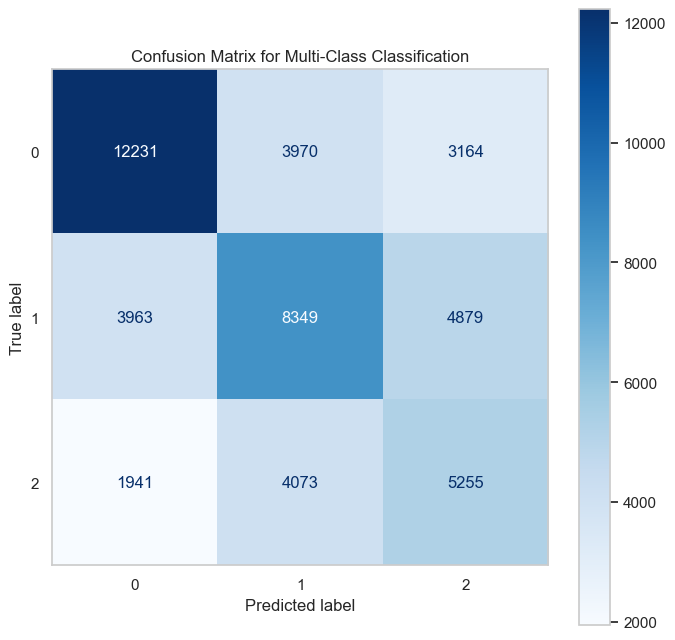

In [222]:
sev_test_predictions_df = sev_test_predictions.select("severity_category", "probability").toPandas()

# Ensure 'probability' is a valid iterable (e.g., numpy array or list)
sev_test_predictions_df['probability'] = sev_test_predictions_df['probability'].apply(
    lambda x: np.array(x) if not isinstance(x, np.ndarray) else x
)

# Extract true labels
y_true = sev_test_predictions_df['severity_category']

# Predicted labels based on the highest probability
y_pred = sev_test_predictions_df['probability'].apply(lambda x: np.argmax(x))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_true))
disp.plot(cmap='Blues', values_format='d', ax=ax)
ax.grid(False)
plt.title("Confusion Matrix for Multi-Class Classification")
plt.show()

New Ideas

- Major Incidents?
- Incident Severity
- New Model - LightGBM?
- Or maybe predicting new features? - Guns to understand guns usage,
- Like understanding what type of guns availability in states
- And many more...

Let's see